In [1]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

import kornia as K
import kornia.metrics as metrics
from torchvision import datasets
import random

# We will use atomai just to create the dataset
import atomai as aoi
import cv2 as cv
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import pyroved as pv
import matplotlib.pyplot as plt

tt = torch.tensor

In [2]:
topo_1 = np.loadtxt("processed data/Topo_B1043_final.txt") 
normalizedData = cv.normalize(topo_1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
coordinates = np.load("coordinates/Topo_B1043_final_coordinates.npy" , allow_pickle=True)

Text(0.5, 1.0, 'Atomic Coordinates')

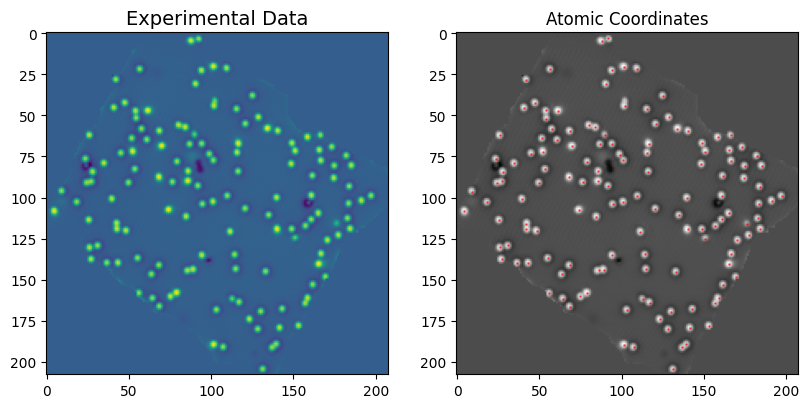

In [3]:
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(normalizedData)
ax1.set_title('Experimental Data', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(normalizedData, cmap='gray')
ax2.scatter(coordinates[:,0], coordinates[:,1], s=1, c='r', alpha = 0.5)
ax2.set_title('Atomic Coordinates')

In [4]:
unique, counts = np.unique(normalizedData, return_counts=True)
dict(zip(unique, counts))

{0: 1,
 4: 1,
 7: 1,
 8: 1,
 9: 2,
 11: 3,
 12: 3,
 13: 2,
 15: 4,
 17: 4,
 18: 4,
 19: 3,
 20: 5,
 21: 1,
 22: 3,
 23: 2,
 25: 1,
 26: 1,
 28: 3,
 31: 2,
 32: 4,
 33: 1,
 34: 1,
 35: 3,
 36: 2,
 37: 3,
 38: 2,
 40: 3,
 41: 5,
 42: 3,
 43: 4,
 44: 4,
 45: 8,
 46: 3,
 47: 4,
 48: 4,
 49: 6,
 50: 5,
 51: 14,
 52: 10,
 53: 15,
 54: 12,
 55: 20,
 56: 41,
 57: 46,
 58: 76,
 59: 94,
 60: 107,
 61: 137,
 62: 155,
 63: 176,
 64: 196,
 65: 212,
 66: 252,
 67: 274,
 68: 318,
 69: 387,
 70: 417,
 71: 472,
 72: 527,
 73: 704,
 74: 880,
 75: 1205,
 76: 20073,
 77: 2602,
 78: 3506,
 79: 3021,
 80: 1922,
 81: 753,
 82: 303,
 83: 176,
 84: 157,
 85: 121,
 86: 111,
 87: 84,
 88: 63,
 89: 77,
 90: 67,
 91: 60,
 92: 67,
 93: 52,
 94: 48,
 95: 56,
 96: 47,
 97: 49,
 98: 49,
 99: 28,
 100: 41,
 101: 40,
 102: 35,
 103: 40,
 104: 26,
 105: 30,
 106: 31,
 107: 22,
 108: 44,
 109: 33,
 110: 30,
 111: 23,
 112: 43,
 113: 17,
 114: 28,
 115: 23,
 116: 33,
 117: 39,
 118: 23,
 119: 28,
 120: 17,
 121: 19,
 122: 

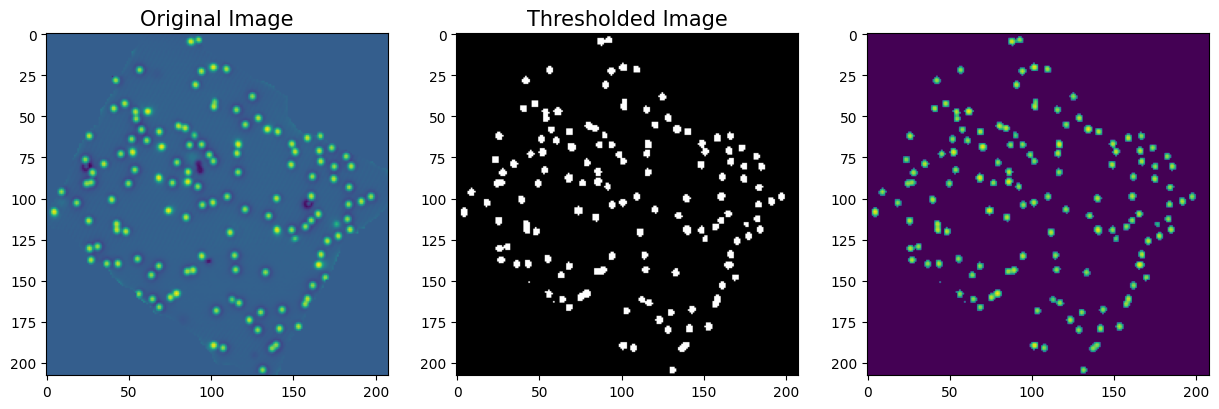

In [5]:
threshData = cv.adaptiveThreshold(normalizedData, 1, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY,25,-29)

nobackgroundData = threshData * normalizedData

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title('Original Image',fontsize=15)
ax[0].imshow(normalizedData)
ax[1].set_title('Thresholded Image',fontsize=15)
ax[1].imshow(threshData,cmap='gray')
ax[2].imshow(nobackgroundData)

In [6]:
window_size = 32
s = aoi.stat.imlocal(
    nobackgroundData,
    coordinates,
    window_size)
imstack = tt(s.imgstack[:,None,:,:, 0], dtype = torch.float32)
train_loader = pv.utils.init_dataloader(imstack, batch_size=3)

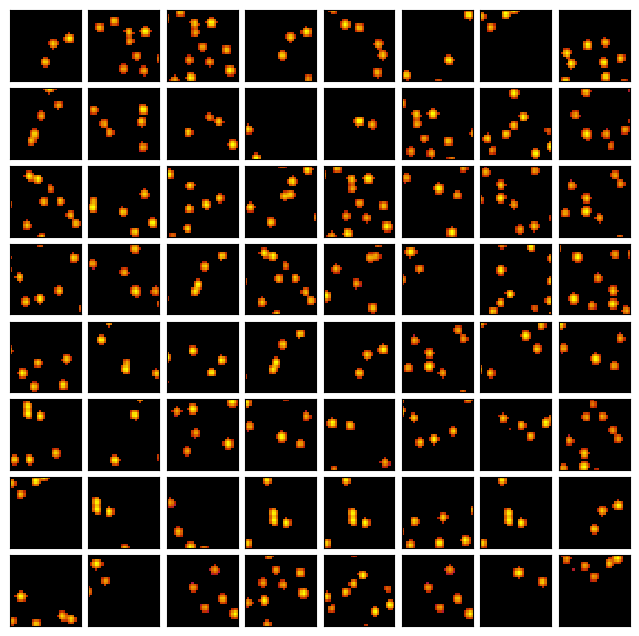

In [7]:
# Visulaizing the training dataset
np.random.seed(15)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

In [8]:
# Training the rVAE on the subimages generated 
# The trained weights will be loaded in the next cell
# So, one can skip this cell to save sometime.

input_dim = (window_size,window_size)   # Input dimensions of the dataset i.e., shape of each card's image
jvae = aoi.models.jrVAE(input_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                          discrete_dim=[2],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)
jvae.fit(imstack[:, 0], training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1, 
                   filename="jrvae_mgo_test1")

/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/200, Training loss: -2872.6619
Epoch: 2/200, Training loss: -20397.0469
Epoch: 3/200, Training loss: -34458.8672
Epoch: 4/200, Training loss: -51834.8008
Epoch: 5/200, Training loss: -67337.7734
Epoch: 6/200, Training loss: -82515.7031
Epoch: 7/200, Training loss: -100168.2656
Epoch: 8/200, Training loss: -117870.0312
Epoch: 9/200, Training loss: -132389.8281
Epoch: 10/200, Training loss: -155065.9375
Epoch: 11/200, Training loss: -168383.3281
Epoch: 12/200, Training loss: -189643.7812
Epoch: 13/200, Training loss: -199231.3750
Epoch: 14/200, Training loss: -205112.7812
Epoch: 15/200, Training loss: -216432.1406
Epoch: 16/200, Training loss: -238674.3438
Epoch: 17/200, Training loss: -255346.5625
Epoch: 18/200, Training loss: -265533.6562
Epoch: 19/200, Training loss: -275128.1250
Epoch: 20/200, Training loss: -288624.5625
Epoch: 21/200, Training loss: -297123.8125
Epoch: 22/200, Training loss: -303989.3125
Epoch: 23/200, Training loss: -324586.4375
Epoch: 24/200, Training los

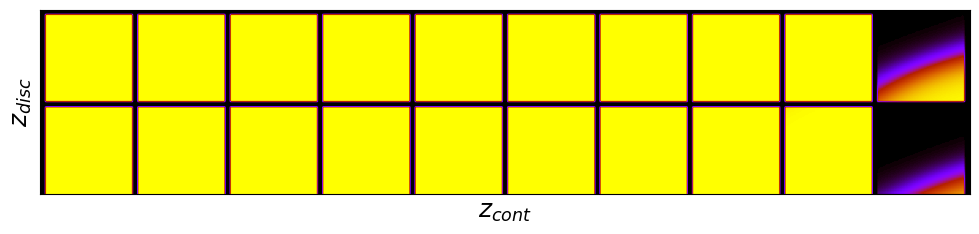

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.0041006 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.72896826, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.7797676 , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.8222168 , 0.        ,
        0.        ]], dtype=float32)

In [9]:
jvae.manifold_traversal(cont_idx=1, origin="upper", cmap="gnuplot2")

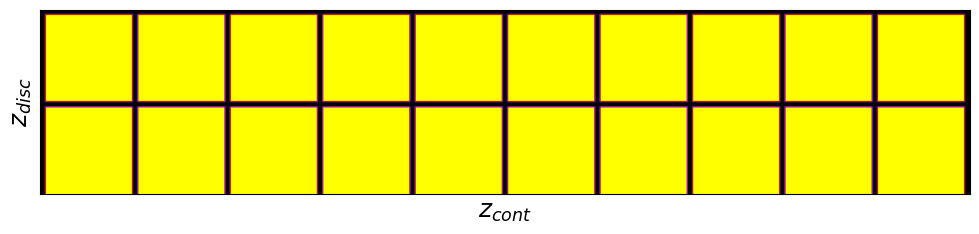

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.99999964, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ]], dtype=float32)

In [12]:
jvae.manifold_traversal(cont_idx=0, origin="upper", cmap="gnuplot2")

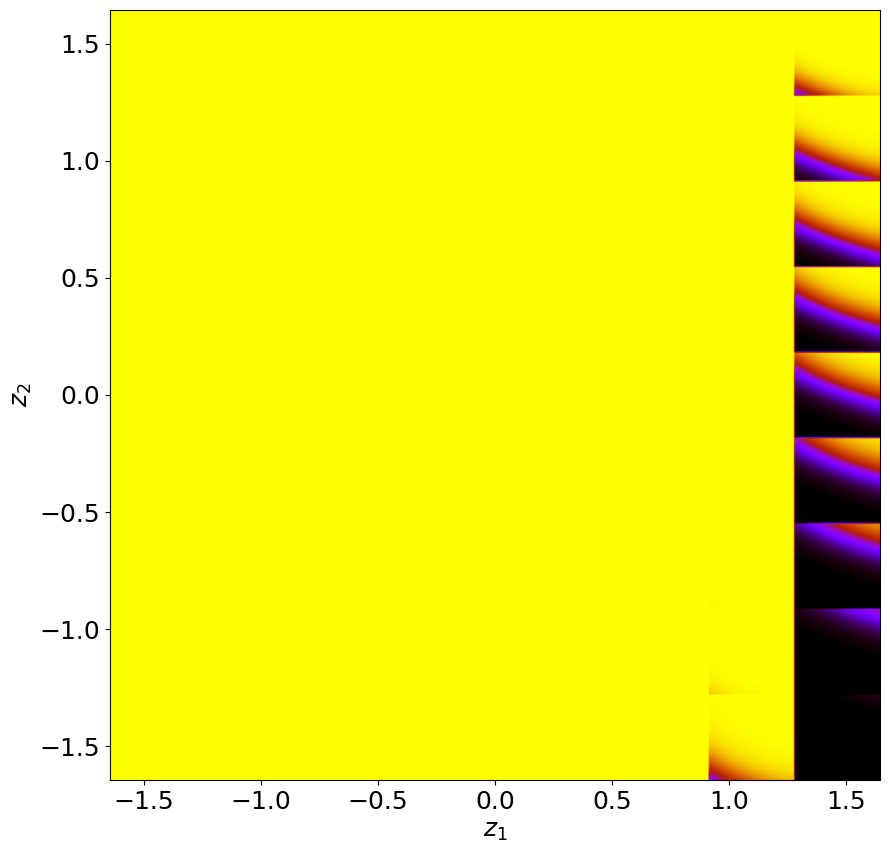

array([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.46457773e-07, 2.91708062e-07, 3.45105093e-07],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        3.61369160e-07, 4.27002220e-07, 5.04268087e-07],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        5.31168553e-07, 6.26502413e-07, 7.38452286e-07],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        9.99982595e-01, 9.99983549e-01, 9.99984384e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        9.99985814e-01, 9.99986529e-01, 9.99987245e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        9.99988317e-01, 9.99988914e-01, 9.99989510e-01]])

In [13]:
jvae.manifold2d()